In [67]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np


from spyglass.common import Session
from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1
from spyglass.decoding.v1.sorted_spikes import SortedSpikesDecodingV1

import os
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying")


from Analysis.utils import filter_opto_data, smooth
from ms_opto_stim_protocol import OptoStimProtocol
# from AnalysisTables import OptoStimTable
os.curdir

from AnalysisTables.decoding_tables import (
    ContinuousRippleTraversal,
    ContinuousRippleTraversalSelection,
    ContinuousRippleTraversalParams,
)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Populate

In [4]:
from AnalysisTables.decoding_tables import (
    ContinuousRippleTraversal,
    ContinuousRippleTraversalSelection,
    ContinuousRippleTraversalParams,
)
from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1
from spyglass.ripple.v1 import RippleTimesV1
from spyglass.position.position_merge import PositionOutput

params = {
    "ripple_traversal_params_name": "default acausal",
    "continuous_distance_threshold": 3,
    "acausal": True,
}
ContinuousRippleTraversalParams().insert1(params, skip_duplicates=True)
ContinuousRippleTraversalParams()

*ripple_traver continuous_dis acausal    
+------------+ +------------+ +---------+
default acausa 3.0            1          
 (Total: 1)

In [ ]:
from Analysis.utils import filter_opto_data

artifact_detection = "ms_lfp_artifact_times"
dataset_key = {"track_type": "early_wtrack"}
dataset = filter_opto_data(dataset_key)
dataset = dataset - "nwb_file_name LIKE 'banner%'"
pos_key = (PositionOutput.DLCPosV1()).proj(pos_merge_id="merge_id")
for key in dataset.fetch("KEY"):
    clusterless_query = ClusterlessDecodingV1() & {
        "nwb_file_name": key["nwb_file_name"],
        "position_group_name": "DLC " + key["interval_list_name"],
        "encoding_interval": key["interval_list_name"],
    }
    if not clusterless_query:
        continue
        # raise ValueError("No clusterless decoding found")
    clusterless_key = clusterless_query.fetch1("KEY")
    clusterless_key
    ripple_key = {
        "nwb_file_name": key["nwb_file_name"],
    }
    ripple_query = (
        RippleTimesV1
        & ripple_key
        # & f"target_interval_list_name LIKE '%{key['interval_list_name']}%'"
        & f"target_interval_list_name LIKE '%{key['interval_list_name']}_{artifact_detection}%'"
        & pos_key
    )
    if not ripple_query:
        continue
        raise ValueError("No ripples found")
    ripple_key = ripple_query.fetch1("KEY")

    insert_key = {
        **ripple_key,
        **clusterless_key,
        "ripple_traversal_params_name": "default acausal",
    }
    ContinuousRippleTraversalSelection().insert1(insert_key, skip_duplicates=True)

    ContinuousRippleTraversalSelection()
ContinuousRippleTraversal().populate(processes=32)

datasets: 86


[2025-03-27 15:27:56,838][WARNING]: Skipped checksum for file with hash: c10048af-56e5-a06a-f9d7-317c69fad593, and path: /stelmo/nwb/analysis/Olive20220711/Olive20220711_3b3621b5-8da9-44d0-9af2-c48c44abc34a.nc
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/xarray/namedarray/core.py:496: UserWarning: Duplicate dimension names present: dimensions {'states'} appear more than once in dims=('states', 'states'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  warnings.warn(
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/xarray/namedarray/core.py:496: UserWarning: Duplicate dimension names present: dimensions {'states'} appear

{'success_count': 68, 'error_list': []}

# Results


(0.0, 100.0)

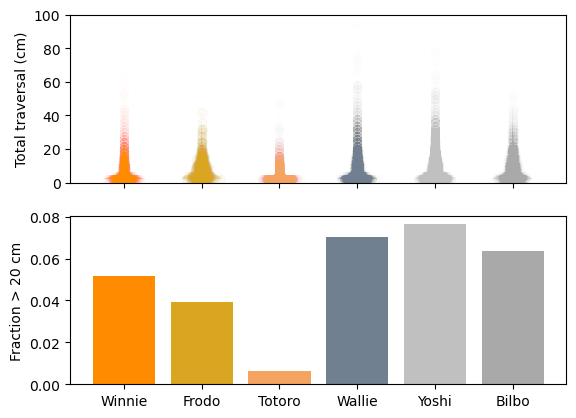

In [ ]:
from Style.style_guide import animal_style
from Analysis.utils import violin_scatter

i = 0
long_thresh = 20  # in cm

data = "longest"


fig, ax = plt.subplots(nrows=2, sharex=True)
animal_list = ["Winnie", "Frodo", "Totoro", "Wallie", "Yoshi", "Bilbo"]
for i, animal in enumerate(animal_list):
    query = (
        ContinuousRippleTraversal()
        & f"nwb_file_name LIKE '{animal}%'"
        & f"target_interval_list_name LIKE '%{artifact_detection}'"
    )
    if not query:
        continue
    df = query.fetch_dataframe()
    if data == "total":
        val = df.total_traversal
    elif data == "longest":
        val = df.longest_traversal * 2  # (puts it in cm)
    else:
        raise ValueError("Data type not recognized")
    violin_scatter(val, color=animal_style.loc[animal, "color"], pos=i, ax=ax[0])

    fract = val > long_thresh

    ax[1].bar(i, fract.mean(), color=animal_style.loc[animal, "color"])

ax[0].set_ylabel("Total traversal (cm)")
ax[1].set_ylabel(f"Fraction > {long_thresh} cm")


ax[1].set_xticks(np.arange(i + 1))
ax[1].set_xticklabels(animal_list)
ax[0].set_ylim(0, 100)

# Plotting exemplar long traces


In [68]:
# Find good long continuous one
# animal = "Totoro"
# animal = "Winnie"
# # animal = "Yoshi"
# animal = "Wallie"

# query_key = f"nwb_file_name LIKE '{animal}%'"

query_key = dict(nwb_file_name="Totoro20220613_.nwb", pos_interval="pos 1 valid times")
query = ContinuousRippleTraversal() & query_key

longest_key = None
max_length = 0

for key in query.fetch("KEY"):
    df = (query & key).fetch1_dataframe()
    if df.longest_traversal.max() > max_length:
        max_length = df.longest_traversal.max()
        longest_key = key

query & longest_key
traversal_df = (query & longest_key).fetch1_dataframe()

In [69]:
Decoder = ClusterlessDecodingV1
# Decoder = SortedSpikesDecodingV1

nwb_file_name = longest_key["nwb_file_name"]
interval = longest_key["position_group_name"].strip("DLC ")
encoding_tag = ""  # "_opto_control_interval"
causal_tag = ""  # "_causal"
key = {
    "nwb_file_name": nwb_file_name,
    "position_group_name": "DLC " + interval,
    "encoding_interval": interval + encoding_tag,
}
key = (
    (Decoder() & key)
    & f"decoding_param_name LIKE '%{causal_tag}'"
    # & "sorted_spikes_group_name NOT LIKE 'manual%'"
).fetch1("KEY")

pos_df = Decoder().fetch_linear_position_info(key)
results = (Decoder() & key).fetch_results()
posterior = results.acausal_posterior.unstack("state_bins").sum("state")[0]
decode_pos = posterior.idxmax("position").values

opto_key = {
    "nwb_file_name": nwb_file_name,
    "interval_list_name": interval,
}
stim, stim_time = OptoStimProtocol().get_stimulus(opto_key)

linear_pos = pos_df["linear_position"].values

if "sorted" in Decoder.full_table_name:
    spikes = Decoder().fetch_spike_data(key)
else:
    spikes = Decoder().fetch_spike_data(key)[0]
flat_spikes = np.concatenate(spikes)
spike_inds = np.digitize(flat_spikes, pos_df.index.values)
mua = np.bincount(spike_inds, minlength=len(pos_df))
mua = smooth(mua, 5)
mua = mua / np.mean(np.diff(pos_df.index.values))
environment = Decoder().fetch_environments(key)[0]
distance_dict = environment.distance_between_nodes_

/home/sambray/Documents/spyglass/src/spyglass/decoding/v1/core.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  position_df[column][st:en] = np.nan
/home/sambray/Documents/spyglass/src/spyglass/decoding/v1/core.py:308: FutureWarning: Ch

In [70]:
from spyglass.lfp.analysis.v1.lfp_band import LFPBandV1
from spyglass.lfp.v1 import LFPV1
from spyglass.lfp.lfp_merge import LFPOutput
from spyglass.ripple.v1 import RippleTimesV1, RippleLFPSelection

LFPV1 & {"nwb_file_name": nwb_file_name, "target_interval_list_name": interval}
artifact_detection = "ms_lfp_artifact_times"
band_query = (
    LFPBandV1()
    & {
        "nwb_file_name": nwb_file_name,
        #    "target_interval_list_name": interval,
        "filter_name": "Ripple 150-250 Hz",
    }
    & "target_interval_list_name LIKE '%{}%'".format(interval)
    & f"target_interval_list_name LIKE '%{artifact_detection}%'"
)

# ripple_band_df = (LFPOutput() & band_query.proj(merge_id="lfp_merge_id")).fetch1_dataframe()

band_query
ripple_band_df = band_query.fetch1_dataframe()

In [44]:
# ripple_query = (
#     RippleLFPSelection.RippleLFPElectrode()
#     & band_query.proj()
#     & ContinuousRippleTraversal().proj()
# )
# ripple_query

In [71]:
state_posterior = results.acausal_posterior.unstack("state_bins").sum("position")[0]
state_posterior.shape

(601079, 2)

In [72]:
traversal_df
from ms_opto_stim_protocol import OptoStimProtocol

longest_key
test_intervals = (
    OptoStimProtocol
    & longest_key
    & {"interval_list_name": longest_key["decoding_interval"]}
).fetch1("test_intervals")

first_test_interval = np.array([test_intervals[0]])

from spyglass.common import interval_list_contains_ind

ind_ripples = interval_list_contains_ind(
    first_test_interval, traversal_df["start_time"].values
)
traversal_df = traversal_df.iloc[ind_ripples]

[08:39:45][WARNING] Spyglass: DEPRECATION scheduled for Spyglass 0.6.0: interval_list_contains_ind
	Use Interval.contains instead


In [73]:
ripple_num = np.argsort(traversal_df.longest_traversal.values)
print(ripple_num)
# Winnie
# ripple_num = ripple_num[-3]
# ripple_num = ripple_num[-2]
# ripple_num = ripple_num[-5]
# Wallie
# ripple_num = ripple_num[-3]
# ripple_num = 294
# Yoshi
# ripple_num = ripple_num[-1]
# ripple_num = ripple_num[-2]
# ripple_num = ripple_num[-3]


ripple_num = ripple_num[-2]
# print(traversal_df.iloc[ripple_num])
st = traversal_df.iloc[ripple_num].start_time
en = traversal_df.iloc[ripple_num].end_time
# traversal_df.iloc[ripple_num]
# longest_key

[  0   1   2  11 105 106  95  96  98  87  90  21  22  24  78  79  80  73
  63  64  65  66  27  28  33  52  43  49  35  37   3   4   5 107 108 110
 111 112 114  18  41  44  42  45  46  48  47 101  94  93  56  55  54  53
  51  62  32  59  67  58  57  31  88  19  20  74  72  71  70  69  68  17
  12  13  14  38  36  39  40  15  86  23  26  10   9   8  89   6  91  16
  77  97  92  34  30  82  84  60  61 104 100 113  83  76  99  29  85 102
  50  25  81   7  75 109 103]


[206036 206037 206038 206039 206040 206041 206042 206043 206044 206045
 206046 206047 206048 206049 206050 206051 206052 206053 206054 206055
 206056 206057 206058 206059 206060 206061 206062 206063 206064 206065
 206066 206067 206068 206069 206070 206071 206072 206073 206074 206075
 206076 206077 206078 206079 206080 206081 206082 206083 206084 206085
 206086 206087 206088 206089 206090 206091 206092 206093 206094 206095
 206096 206097 206098 206099 206100 206101 206102 206103 206104 206105
 206106 206107 206108 206109 206110 206111 206112 206113 206114 206115
 206116 206117 206118 206119 206120 206121 206122 206123 206124 206125
 206126 206127 206128 206129 206130 206131 206132 206133 206134 206135
 206136 206137 206138 206139 206140 206141 206142 206143 206144 206145
 206146 206147 206148 206149 206150 206151 206152 206153 206154 206155
 206156 206157 206158 206159 206160 206161 206162 206163 206164 206165
 206166 206167 206168 206169 206170 206171 206172 206173 206174 206175
 20617

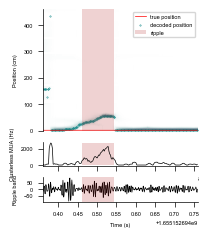

In [79]:
# pos_df
posterior.shape, pos_df.shape

# t0 = pos_df.index.values[0] - 9 * 60 + 30.4
t0 = 0

t_rng = (st - 0.1, st + 0.3)
# t_rng = (st - 0.1, st + 0.5)

plt.rcParams.update({"font.size": 4})
lw = 0.5
plt.rcParams.update({"lines.linewidth": lw})
plt.rcParams.update({"axes.linewidth": lw})
plt.rcParams["xtick.major.width"] = lw  # Width of major x-ticks
plt.rcParams["ytick.major.width"] = lw
fig, ax = plt.subplots(
    nrows=3,
    figsize=(2, 2.5),
    # figsize=(6, 7.5),
    sharex=False,
    height_ratios=[20, 4, 4],
)
# ax = [ax]
ind = np.where(
    (pos_df.index.values >= t0 + t_rng[0]) & (pos_df.index.values < t0 + t_rng[1])
)[0]

ind

print(ind)
# ax[0].imshow(
#     posterior[ind].T,
#     aspect=0.0005,
#     extent=[*t_rng, results.position.max() + results.position.min() + 0, 0],
#     cmap="bone_r",
#     clim=[0, 0.05],
#     zorder=-1,
# )
t_plot = pos_df.index[ind].values  # - t0
xx, yy = np.meshgrid(t_plot, results.position)
pos_val = results.position.values
pos_val = pos_val[: pos_val.shape[0] // 2]
XX, YY = np.meshgrid(t_plot, pos_val)
clim = None
ax[0].pcolormesh(
    XX,
    YY,
    posterior[ind].T,
    cmap="bone_r",
    shading="nearest",
    clim=clim,
    rasterized=True,
)
# ax[0].scatter(t_plot, linear_pos[ind], color="r", s=.15)

ax[0].plot(t_plot, linear_pos[ind], "r", label="true position")
ax[0].scatter(t_plot, decode_pos[ind], color="teal", s=0.1, label="decoded position")


ax[1].plot(t_plot, mua[ind], "k")

# ripples
ind_ripple = np.where(
    np.logical_and(
        (ripple_band_df.index.values >= t0 + t_rng[0]),
        (ripple_band_df.index.values < t0 + t_rng[1]),
    )
)[0]
t_rip = ripple_band_df.index[ind_ripple]
y_rip = ripple_band_df.iloc[ind_ripple].values[:, 2].astype(float)
gaps = np.where(np.diff(t_rip) > 0.01)[0] + 1
y_rip[gaps] = 1.0 * np.nan
ax[2].plot(t_rip, y_rip, "k")
ax[2].set_ylabel("Ripple band")
rip_lo = np.nanmin(y_rip) * 1.05
rip_hi = np.nanmax(y_rip) * 1.05
ax[2].fill_between(
    [st, en], rip_lo, rip_hi, facecolor="firebrick", alpha=0.2, zorder=10
)
ax[2].set_ylim(rip_lo, rip_hi)


ax[0].fill_between(
    [st, en],
    0,
    np.nanmax(linear_pos),
    facecolor="firebrick",
    alpha=0.2,
    zorder=10,
    label="ripple",
)
ax[1].fill_between(
    [st, en], 0, np.nanmax(mua[ind]), facecolor="firebrick", alpha=0.2, zorder=0
)

ax[-1].set_xlabel("Time (s)")
ax[0].set_ylabel("Position (cm)")
# ax[0].set_title(f"{nwb_file_name}, {interval}, ripple {ripple_num}")
ax[1].set_ylabel("Clusterless MUA (Hz)")
ax[0].legend()

for a in ax:
    a.spines[["top", "right"]].set_visible(False)
    a.set_xlim(t_rng)
ax[0].spines[["bottom"]].set_visible(False)
ax[0].set_xticks([])
# ax[1].set_xticks([])
# ax[0].set_ylim(0, 100)
plt.rcParams["svg.fonttype"] = "none"
# fig.savefig(
#     f"Figures_20241201/ripple_examples/{nwb_file_name}_{interval}_ripple_{ripple_num}_rasterized.svg"
# )
# fig.savefig(
#     f"/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250210/ripple_examples/{nwb_file_name}_{interval}_ripple_{ripple_num}_rasterized.svg"
# )

# fig.savefig(
#     f"/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250210/ripple_examples/pre_control_{nwb_file_name}_{interval}_ripple_{ripple_num}_rasterized.svg"
# )
fig.savefig(
    f"/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/wtrack_first_epoch_{nwb_file_name}_{interval}_ripple_{ripple_num}_rasterized.svg"
)

In [ ]:
(traversal_df.iloc[ripple_num].start_time - first_test_interval[0][0]) / 60

1.2413055380185445

In [20]:
import os

os.listdir("/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250210/")

['stim_field_interact_linear_theta90.svg',
 'lineartrack_theta90_phase_histogram.svg',
 "kl_change_placeField_stimOn_{'animal': 'control', 'track_type': 'lineartrack', 'targeted_phase': 90, 'laser_power': 77}.svg",
 'wtrack_examples_Winnie20220719_pos 3 valid times_index41250_acausal_rasterized.svg',
 'ripple_content.svg',
 'wtrack_decode_stim_response_all_aheadBehind_noClip.svg',
 'wtrack_examples_Winnie20220719_pos 3 valid times_index14501_acausal_rasterized.svg',
 'wtrack_examples_Frodo20230814_pos 15 valid times_index155501_acausal_rasterized.svg',
 'wtrack_decode_stim_response_all_aheadBehind_Clip.svg',
 'decode_error_pooled.svg',
 'wtrack_examples_Frodo20230814_pos 15 valid times_index34501_acausal_rasterized.svg',
 'wtrack_examples_Yoshi20220517_pos 5 valid times_index269501_acausal_rasterized.svg',
 'wtrack_examples_Wallie20220922_pos 3 valid times_index60100_acausal_rasterized.svg',
 'wtrack_examples_Winnie20220719_pos 3 valid times_index485596_acausal_rasterized.svg',
 'wtrac

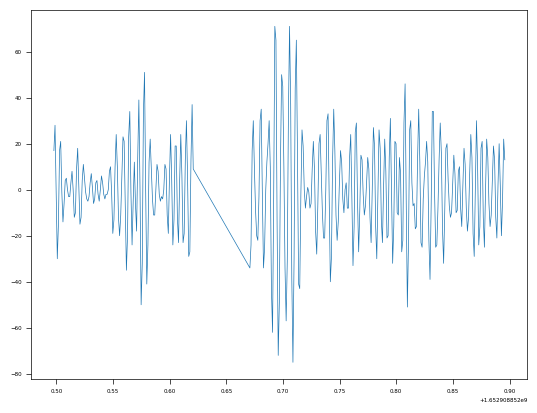

In [65]:
i = 4
plt.plot(ripple_band_df.index[ind_ripple], ripple_band_df[i].iloc[ind_ripple])

# Control Animal

In [36]:
ClusterlessDecodingV1 & {
    "nwb_file_name": "Winnie20220719_.nwb",
}

*nwb_file_name *waveform_feat *position_grou *decoding_para *encoding_inte *decoding_inte *estimate_deco results_pa classifier
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +--------+ +--------+
Winnie20220719 02_wtrack      DLC pos 1 vali ms_wtrack_cont pos 1 valid ti pos 1 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 02_wtrack      DLC pos 1 vali ms_wtrack_cont pos 1 valid ti pos 1 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 02_wtrack      DLC pos 1 vali ms_wtrack_cont pos 1 valid ti pos 1 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 02_wtrack      DLC pos 1 vali ms_wtrack_cont pos 1 valid ti pos 1 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 04_wtrack      DLC pos 3 vali ms_wtrack_cont pos 3 valid ti pos 3 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 04_wtrack      DLC pos 3 vali ms_wtrack_cont pos 3 valid ti pos 3 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 04_wtrack      DLC pos 3 vali ms_wtrack_cont pos 3 valid ti pos 3 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 04_wtrack      DLC pos 3 vali ms_wtrack_cont pos 3 valid ti pos 3 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 06_wtrack      DLC pos 5 vali ms_wtrack_cont pos 5 valid ti pos 5 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 06_wtrack      DLC pos 5 vali ms_wtrack_cont pos 5 valid ti pos 5 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 06_wtrack      DLC pos 5 vali ms_wtrack_cont pos 5 valid ti pos 5 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 06_wtrack      DLC pos 5 vali ms_wtrack_cont pos 5 valid ti pos 5 valid ti 0              =BLOB=     =BLOB=    
   ...
 (Total: 36)

In [80]:
Decoder = ClusterlessDecodingV1
# Decoder = SortedSpikesDecodingV1

interval = "pos 1 valid times"
encoding_tag = ""  # "_opto_control_interval"
causal_tag = ""  # "_causal"
key = {
    "nwb_file_name": "Yoshi20220517_.nwb",
    "position_group_name": "DLC " + interval,
    "encoding_interval": interval + encoding_tag,
}
key = (
    (Decoder() & key)
    & f"decoding_param_name LIKE '%{causal_tag}'"
    # & "sorted_spikes_group_name NOT LIKE 'manual%'"
).fetch1("KEY")

pos_df = Decoder().fetch_linear_position_info(key)
results = (Decoder() & key).fetch_results()
posterior = results.acausal_posterior.unstack("state_bins").sum("state")[0]
decode_pos = posterior.idxmax("position").values

opto_key = {
    "nwb_file_name": key["nwb_file_name"],
    "interval_list_name": interval,
}
stim, stim_time = OptoStimProtocol().get_stimulus(opto_key)

linear_pos = pos_df["linear_position"].values

if "sorted" in Decoder.full_table_name:
    spikes = Decoder().fetch_spike_data(key)
else:
    spikes = Decoder().fetch_spike_data(key)[0]
flat_spikes = np.concatenate(spikes)
spike_inds = np.digitize(flat_spikes, pos_df.index.values)
mua = np.bincount(spike_inds, minlength=len(pos_df))
mua = smooth(mua, 5)
environment = Decoder().fetch_environments(key)[0]
distance_dict = environment.distance_between_nodes_

/home/sambray/Documents/spyglass/src/spyglass/decoding/v1/core.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  position_df[column][st:en] = np.nan
/home/sambray/Documents/spyglass/src/spyglass/decoding/v1/core.py:308: FutureWarning: Ch

In [81]:
query = ContinuousRippleTraversal() & key
query
longest_key = None
max_length = 0

for key in query.fetch("KEY"):
    df = (query & key).fetch1_dataframe()
    if df.longest_traversal.max() > max_length:
        max_length = df.longest_traversal.max()
        longest_key = key

query & longest_key
traversal_df = (query & longest_key).fetch1_dataframe()

In [82]:
from spyglass.lfp.analysis.v1.lfp_band import LFPBandV1
from spyglass.lfp.v1 import LFPV1
from spyglass.lfp.lfp_merge import LFPOutput
from spyglass.ripple.v1 import RippleTimesV1, RippleLFPSelection

LFPV1 & {
    "nwb_file_name": key["nwb_file_name"],
    "target_interval_list_name": key["target_interval_list_name"],
}
artifact_detection = "ms_lfp_artifact_times"
band_query = (
    LFPBandV1()
    & {
        "nwb_file_name": key["nwb_file_name"],
        #    "target_interval_list_name": interval,
        "filter_name": "Ripple 150-250 Hz",
    }
    & "target_interval_list_name LIKE '%{}%'".format("pos 1 valid times")
    & f"target_interval_list_name LIKE '%{artifact_detection}%'"
)

# ripple_band_df = (LFPOutput() & band_query.proj(merge_id="lfp_merge_id")).fetch1_dataframe()

band_query
ripple_band_df = band_query.fetch1_dataframe()

In [35]:
band_query

*lfp_merge_id  *filter_name   *filter_sampli *nwb_file_name *target_interv *lfp_band_samp analysis_file_ interval_list_ lfp_band_objec
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
8f3ec2e4-c512- Ripple 150-250 1000           Totoro20220613 pos 1 valid ti 1000           Totoro20220613 pos 1 valid ti ed7a193d-916b-
 (Total: 1)

In [83]:
state_posterior = results.acausal_posterior.unstack("state_bins").sum("position")[0]
state_posterior.shape

(603779, 2)

In [84]:
# traversal_df.iloc[ripple_num]
# longest_key

[121 132 134 122 123 124 125 126 127 251  12  14  15  16  17 227 220 221
 222 223 225  26  30 214 215 216  35  39  40 202 204 205 206 199 200 201
  42  43  44  46  49 187 189 190 191 192 193  50  51  53  56  58  59  60
  61  62  63  64  66  67  68  69  70  71 179 180 181 185  76 170 171 173
 174 175 176  84  85  87  88  89 162 164 168 169  91  93  94  95  96  97
  98  99 104 154 155 159 160 147 148 149 150 151 153 107 140 141 142 144
 114 118 119 120 228 229 230 231  18  19  23 219   3   5   6   7   9 246
 252   4   8 133 135  20  21  27  31  32  33 218 137 138 139 143  37  41
 145 106 110 113 197 203 208 152 156 158 100 101  48 194 195 196 102 105
 166 184  52  78  80  81 167  82  86  75 249 239 240 242  74 172 226 183
 115 238 241  45  47 186 165  57 163  55 108 236 233  65  73  77 247  83
 182   2 248  29 112 116 157  10 250 232  11 131 130  13 245 198 146 188
 209 210  38 178 136  36 235   0 109  79 212 211  34  90  28 243 244  54
 103 234 117 161  92  72 129  22 128  24 177 213  2

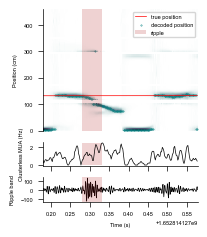

In [86]:
# pos_df

for ii in range(1):
    ripple_num = np.argsort(traversal_df.longest_traversal.values)
    print(ripple_num)
    ripple_num = ripple_num[-ii]

    ripple_num = 117
    # print(traversal_df.iloc[ripple_num])
    st = traversal_df.iloc[ripple_num].start_time
    en = traversal_df.iloc[ripple_num].end_time

    posterior.shape, pos_df.shape

    # t0 = pos_df.index.values[0] - 9 * 60 + 30.4
    t0 = 0

    t_rng = (st - 0.1, st + 0.3)
    # t_rng = (st - 0.1, st + 0.5)

    plt.rcParams.update({"font.size": 4})
    lw = 0.5
    plt.rcParams.update({"lines.linewidth": lw})
    plt.rcParams.update({"axes.linewidth": lw})
    plt.rcParams["xtick.major.width"] = lw  # Width of major x-ticks
    plt.rcParams["ytick.major.width"] = lw
    fig, ax = plt.subplots(
        nrows=3,
        figsize=(2, 2.5),
        # figsize=(6, 7.5),
        sharex=False,
        height_ratios=[20, 4, 4],
    )
    # ax = [ax]
    ind = np.where(
        (pos_df.index.values >= t0 + t_rng[0]) & (pos_df.index.values < t0 + t_rng[1])
    )[0]

    ind

    print(ind)
    # ax[0].imshow(
    #     posterior[ind].T,
    #     aspect=0.0005,
    #     extent=[*t_rng, results.position.max() + results.position.min() + 0, 0],
    #     cmap="bone_r",
    #     clim=[0, 0.05],
    #     zorder=-1,
    # )
    t_plot = pos_df.index[ind].values  # - t0
    xx, yy = np.meshgrid(t_plot, results.position)
    pos_val = results.position.values
    pos_val = pos_val[: pos_val.shape[0] // 2]
    XX, YY = np.meshgrid(t_plot, pos_val)
    clim = None
    ax[0].pcolormesh(
        XX,
        YY,
        posterior[ind].T,
        cmap="bone_r",
        shading="nearest",
        clim=clim,
        rasterized=True,
    )
    # ax[0].scatter(t_plot, linear_pos[ind], color="r", s=.15)

    ax[0].plot(t_plot, linear_pos[ind], "r", label="true position")
    ax[0].scatter(
        t_plot, decode_pos[ind], color="teal", s=0.1, label="decoded position"
    )

    ax[1].plot(t_plot, mua[ind], "k")

    # ripples
    ind_ripple = np.where(
        np.logical_and(
            (ripple_band_df.index.values >= t0 + t_rng[0]),
            (ripple_band_df.index.values < t0 + t_rng[1]),
        )
    )[0]
    t_rip = ripple_band_df.index[ind_ripple]
    y_rip = ripple_band_df.iloc[ind_ripple].values[:, 2].astype(float)
    gaps = np.where(np.diff(t_rip) > 0.01)[0] + 1
    y_rip[gaps] = 1.0 * np.nan
    ax[2].plot(t_rip, y_rip, "k")
    ax[2].set_ylabel("Ripple band")
    rip_lo = np.nanmin(y_rip) * 1.05
    rip_hi = np.nanmax(y_rip) * 1.05
    ax[2].fill_between(
        [st, en], rip_lo, rip_hi, facecolor="firebrick", alpha=0.2, zorder=10
    )
    ax[2].set_ylim(rip_lo, rip_hi)

    ax[0].fill_between(
        [st, en],
        0,
        np.nanmax(linear_pos),
        facecolor="firebrick",
        alpha=0.2,
        zorder=10,
        label="ripple",
    )
    ax[1].fill_between(
        [st, en], 0, np.nanmax(mua[ind]), facecolor="firebrick", alpha=0.2, zorder=0
    )

    ax[-1].set_xlabel("Time (s)")
    ax[0].set_ylabel("Position (cm)")
    # ax[0].set_title(f"{nwb_file_name}, {interval}, ripple {ripple_num}")
    ax[1].set_ylabel("Clusterless MUA (Hz)")
    ax[0].legend()

    for a in ax:
        a.spines[["top", "right"]].set_visible(False)
        a.set_xlim(t_rng)
    ax[0].spines[["bottom"]].set_visible(False)
    ax[0].set_xticks([])
    # ax[0].set_ylim(0, 100)
    plt.rcParams["svg.fonttype"] = "none"
    # fig.savefig(
    #     f"Figures_20241201/ripple_examples/{nwb_file_name}_{interval}_ripple_{ripple_num}_rasterized.svg"
    # )
    # fig.savefig(
    #     f"/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250210/ripple_examples/{nwb_file_name}_{interval}_ripple_{ripple_num}_rasterized.svg"
    # )

    # fig.savefig(
    #     f"/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250210/ripple_examples/pre_control_{nwb_file_name}_{interval}_ripple_{ripple_num}_rasterized.svg"
    # )
    plt.rcParams["svg.fonttype"] = "none"
    plt.rcParams["font.family"] = "Arial"
    fig.savefig(
        f"/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/wtrack_first_epoch_{key['nwb_file_name']}_{interval}_ripple_{ripple_num}_rasterized.svg"
    )